# Model Comparison

In [2]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
az.style.use('arviz-darkgrid')

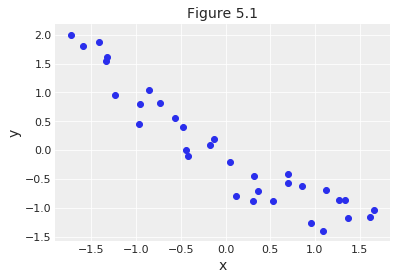

In [6]:
dummy_data = np.loadtxt('../data/dummy.csv')
x_1 = dummy_data[:,0]
y_1 = dummy_data[:,1]

order = 2
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()
plt.scatter(x_1s[0], y_1s);
plt.xlabel('x')
plt.ylabel('y')
plt.title('Figure 5.1')
plt.savefig('B11197_05_01.png', dpi=300)

In [7]:
with pm.Model() as model_l:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = α + β * x_1s[0]
    
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)

    trace_l = pm.sample(2000)

with pm.Model() as model_p:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = α + pm.math.dot(β, x_1s)
    
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)

    trace_p = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:02<00:00, 2498.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:04<00:00, 1235.19draws/s]


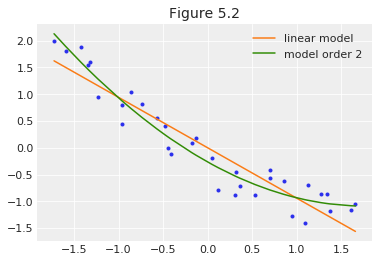

In [8]:
x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)

α_l_post = trace_l['α'].mean()
β_l_post = trace_l['β'].mean(axis=0)
y_l_post = α_l_post + β_l_post *  x_new

plt.plot(x_new, y_l_post, 'C1', label='linear model')

α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
idx = np.argsort(x_1s[0])
y_p_post = α_p_post + np.dot(β_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], 'C2', label=f'model order {order}')

α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
x_new_p = np.vstack([x_new**i for i in range(1, order+1)])
y_p_post = α_p_post + np.dot(β_p_post, x_new_p) 

#plt.plot(x_nuevo_p[0], y_p_post, label='Bayes pol orden {} outrange'.format(orden))


plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend();
plt.title('Figure 5.2')
plt.savefig('B11197_05_02.png', dpi=300)

## Posterior predictive checks

In [9]:
y_l = pm.sample_ppc(trace_l, 2000, model=model_l)['y_pred']
y_p = pm.sample_ppc(trace_p, 2000, model=model_p)['y_pred']

100%|██████████| 2000/2000 [00:01<00:00, 1498.83it/s]


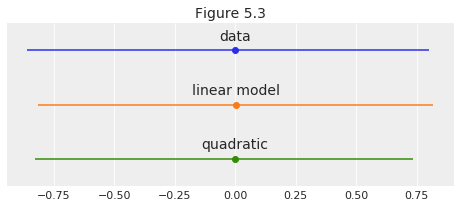

In [10]:
plt.figure(figsize=(8, 3))
data = [y_1s, y_l, y_p]
labels = ['data', 'linear model', 'quadratic']
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([]);
plt.title('Figure 5.3')
plt.savefig('B11197_05_03.png', dpi=300)

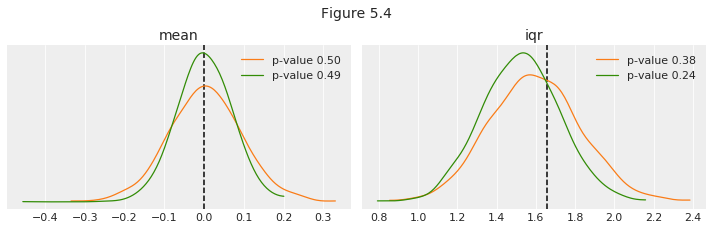

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

for idx, func in enumerate([np.mean, iqr]):
    T_obs = func(y_1s)
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    for d_sim, c in zip([y_l, y_p], ['C1', 'C2']):
        T_sim = func(d_sim, 1)
        p_value = np.mean(T_sim >= T_obs)
        az.kdeplot(T_sim, plot_kwargs={'color':c},
                   label=f'p-value {p_value:.2f}', ax=ax[idx])
    ax[idx].set_title(func.__name__)
    ax[idx].set_yticks([])
    ax[idx].legend()
plt.tight_layout()
fig.text(0.5, 1, 'Figure 5.4', fontsize=14, ha='center')
plt.savefig('B11197_05_04.png', dpi=300, bbox_inches='tight')

# Occam's razor – simplicity and accuracy 

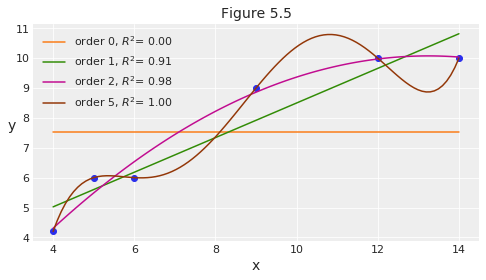

In [12]:
x = np.array([4.,5.,6.,9.,12, 14.])
y = np.array([4.2, 6., 6., 9., 10, 10.])

plt.figure(figsize=(8, 4))
order = [0, 1, 2, 5]
plt.plot(x, y, 'o')
for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)
    
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2) 
    r2 = ssreg / sstot

    plt.plot(x_n, ffit, label='order {}, $R^2$= {:.2f}'.format(i, r2))

plt.legend(loc=2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title('Figure 5.5')
plt.savefig('B11197_05_05.png', dpi=300)
#plt.plot([10, 7], [9, 7], 'ks')
#plt.title('Figure 5.6')
#plt.savefig('B11197_05_06.png', dpi=300)

## Computing information criteria with PyMC3

In [13]:
waic_l = az.waic(trace=trace_l, model=model_l)
waic_l

,waic,waic_se,p_waic,warning
0,28.717411,5.358861,2.43236,0


In [14]:
waic_p = az.waic(trace=trace_p, model=model_p)
waic_p

,waic,waic_se,p_waic,warning
0,9.105624,4.621792,2.626363,0


In [15]:
loo_l = az.loo(trace=trace_l, model=model_l)
loo_l

,loo,loo_se,p_loo,warning
0,28.768329,5.368851,2.45782,0


In [16]:
loo_p = az.loo(trace=trace_p, model=model_p)
loo_p

,loo,loo_se,p_loo,warning
0,9.162671,4.626512,2.654886,0


In [17]:
cmp_df = az.compare({model_l:trace_l, model_p:trace_p}, method='BB-pseudo-BMA')
cmp_df

,waic,pwaic,dwaic,weight,se,dse,warning
1,9.11,2.63,0,1,5.19,0,0
0,28.72,2.43,19.61,0,4.66,5.34,0


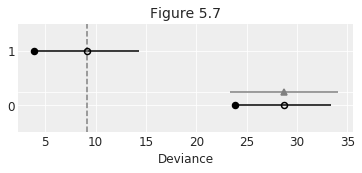

In [18]:
az.compareplot(cmp_df)
plt.title('Figure 5.7')
plt.savefig('B11197_05_07.png', dpi=300)

## Model Averaging

In [46]:
w = 0.5
y_lp = pm.sample_ppc_w([trace_l, trace_p], samples=1000, models=[model_l, model_p],
                       weights=[w, 1-w])

100%|██████████| 1000/1000 [00:00<00:00, 1844.69it/s]


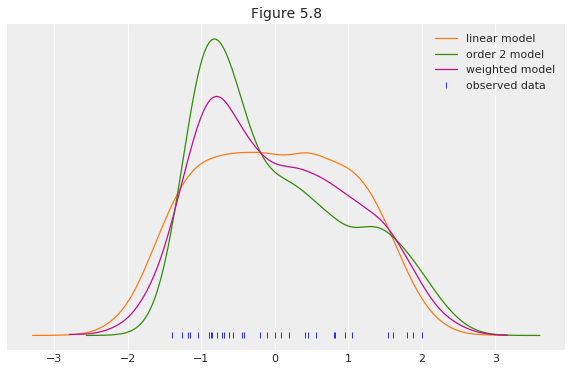

In [53]:
_, ax = plt.subplots(figsize=(10, 6))
az.kdeplot(y_l, plot_kwargs={'color':'C1'}, label='linear model', ax=ax)
az.kdeplot(y_p, plot_kwargs={'color':'C2'}, label='order 2 model', ax=ax)
az.kdeplot(y_lp['y_pred'], plot_kwargs={'color':'C3'}, label='weighted model', ax=ax)

plt.plot(y_1s, np.zeros_like(y_1s), '|', label='observed data')
plt.yticks([])
plt.legend();
plt.title('Figure 5.8')
plt.savefig('B11197_05_08.png', dpi=300)

# Bayes factors

In [ ]:
coins = 30 # 300
heads = 9 # 90
y_d = np.repeat([0, 1], [coins-heads, heads])

In [ ]:
with pm.Model() as model_BF:
    p = np.array([0.5, 0.5])
    model_index = pm.Categorical('model_index', p=p)
    
    m_0 = (4, 8)
    m_1 = (8, 4)
    m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)

    # a priori
    theta = pm.Beta('theta', m[0], m[1])
    # likelihood
    y = pm.Bernoulli('y', theta, observed=y_d)
     
    trace_BF = pm.sample(5000)
az.traceplot(trace_BF)
plt.title('Figure 5.10')
plt.savefig('B11197_05_10.png', dpi=300)

In [ ]:
pM1 = trace_BF['model_index'].mean()
pM0 = 1 - pM1
BF = (pM0 / pM1) * (p[1] / p[0])
BF

In [ ]:
with pm.Model() as model_BF_0:
    theta = pm.Beta('theta', 4, 8)
    y = pm.Bernoulli('y', theta, observed=y_d)
    trace_BF_0 = pm.sample(2500, step=pm.SMC())

with pm.Model() as model_BF_1:
    theta = pm.Beta('theta', 8, 4)
    y = pm.Bernoulli('y', theta, observed=y_d)
    trace_BF_1 = pm.sample(2500, step=pm.SMC())

In [ ]:
model_BF_0.marginal_likelihood / model_BF_1.marginal_likelihood

## Bayes factors and information criteria

In [ ]:
traces = []
waics = []
for coins, heads in [(30, 9), (300, 90)]:
    y_d = np.repeat([0, 1], [coins-heads, heads])
    for priors in [(4, 8), (8, 4)]: 
        with pm.Model() as model:
            theta = pm.Beta('theta', *priors)
            y = pm.Bernoulli('y', theta, observed=y_d)
            trace = pm.sample(2000)
            traces.append(trace)
            waics.append(pm.waic(trace, model))

In [ ]:
model_names = ['Model_0 (30-9)', 'Model_1 (30-9)','Model_0 (300-90)', 'Model_1 (300-90)']

az.forestplot(traces, model_names=model_names, combined=False, r_hat=False, n_eff=False)
plt.title('Figure 5.11')
plt.savefig('B11197_05_11.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, 2, sharey=True)

labels = model_names
indices = [0, 0, 1, 1]
for i, (ind, d) in enumerate(zip(indices, waics)):
    mean = d.WAIC
    ax[ind].errorbar(mean, -i, xerr=d.WAIC_se, fmt='o')
    ax[ind].text(mean, -i+0.2, labels[i], ha='center', fontsize=14)

ax[0].set_xlim(30,50)
ax[1].set_xlim(330,400)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])
plt.subplots_adjust(wspace=0.05)
fig.text(0.5, 0, 'Deviance', ha='center', fontsize=11)
fig.text(0.5, .95, 'Figure 5.12', ha='center', fontsize=14)
plt.savefig('B11197_05_12.png', dpi=300)

## Regularizing priors

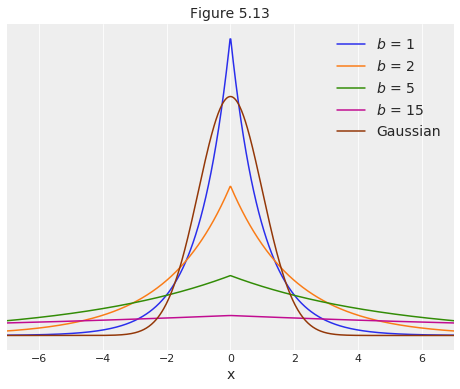

In [6]:
plt.figure(figsize=(8, 6))
x_values = np.linspace(-10, 10, 1000)
for df in [1, 2, 5, 15]:
    distri = stats.laplace(scale=df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label='$b$ = {}'.format(df))

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label='Gaussian')
plt.xlabel('x')
plt.yticks([])
plt.legend(loc=0, fontsize=14)
plt.xlim(-7, 7);
plt.title('Figure 5.13')
plt.savefig('B11197_05_13.png', dpi=300)